Deep Learning
=============

Assignment 4
------------

Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) characters.

The goal of this assignment is make the neural network convolutional.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

In [15]:
# Some personnal imports
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pickle_file = 'data/notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [5]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [6]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.694511
Minibatch accuracy: 0.0%
Validation accuracy: 10.0%
Minibatch loss at step 50: 1.584385
Minibatch accuracy: 43.8%
Validation accuracy: 61.9%
Minibatch loss at step 100: 1.191001
Minibatch accuracy: 62.5%
Validation accuracy: 69.8%
Minibatch loss at step 150: 0.704988
Minibatch accuracy: 81.2%
Validation accuracy: 77.4%
Minibatch loss at step 200: 0.566068
Minibatch accuracy: 87.5%
Validation accuracy: 78.3%
Minibatch loss at step 250: 1.337007
Minibatch accuracy: 68.8%
Validation accuracy: 79.1%
Minibatch loss at step 300: 0.675867
Minibatch accuracy: 81.2%
Validation accuracy: 79.5%
Minibatch loss at step 350: 0.326337
Minibatch accuracy: 100.0%
Validation accuracy: 79.3%
Minibatch loss at step 400: 0.708448
Minibatch accuracy: 81.2%
Validation accuracy: 76.4%
Minibatch loss at step 450: 0.437135
Minibatch accuracy: 93.8%
Validation accuracy: 81.4%
Minibatch loss at step 500: 0.592598
Minibatch accuracy: 75.0%
Validation accuracy: 80.8%
M

### Saving Model Accuracy

We'll plot a graph with the accuracy results of each model at the end of the assignment.

In [7]:
methodDict = {}

---
Problem 1
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

---

In [8]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    # Convolution 1   
    conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    
    bias1 = tf.nn.relu(conv1 + layer1_biases)
    # Pooling 1
    pool1 = tf.nn.max_pool(bias1, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    
    # Convolution 2
    conv2 = tf.nn.conv2d(pool1, layer2_weights, [1, 1, 1, 1], padding='SAME')
    bias2 = tf.nn.relu(conv2 + layer2_biases)
    
    # Pooling 2
    pool2 = tf.nn.max_pool(bias2, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    shape = pool2.get_shape().as_list()
    reshape = tf.reshape(pool2, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [9]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
  methodDict['Max pooling model'] = accuracy(test_prediction.eval(), test_labels)
print(methodDict)

Initialized
Minibatch loss at step 0: 2.940207
Minibatch accuracy: 12.5%
Validation accuracy: 10.0%
Minibatch loss at step 50: 1.900450
Minibatch accuracy: 31.2%
Validation accuracy: 41.8%
Minibatch loss at step 100: 1.383264
Minibatch accuracy: 50.0%
Validation accuracy: 65.1%
Minibatch loss at step 150: 0.786751
Minibatch accuracy: 68.8%
Validation accuracy: 76.0%
Minibatch loss at step 200: 0.362062
Minibatch accuracy: 87.5%
Validation accuracy: 78.8%
Minibatch loss at step 250: 1.302935
Minibatch accuracy: 62.5%
Validation accuracy: 80.2%
Minibatch loss at step 300: 0.518037
Minibatch accuracy: 81.2%
Validation accuracy: 80.6%
Minibatch loss at step 350: 0.357974
Minibatch accuracy: 87.5%
Validation accuracy: 80.3%
Minibatch loss at step 400: 0.846707
Minibatch accuracy: 75.0%
Validation accuracy: 78.4%
Minibatch loss at step 450: 0.334236
Minibatch accuracy: 93.8%
Validation accuracy: 82.1%
Minibatch loss at step 500: 0.540606
Minibatch accuracy: 81.2%
Validation accuracy: 81.5%
M

---
Problem 2
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

---

### LeNet5 Model

In [10]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  size3 = ((image_size - patch_size + 1) // 2 - patch_size + 1) // 2
  layer3_weights = tf.Variable(tf.truncated_normal(
      [size3 * size3 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    # C1 input 28 x 28
    conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='VALID')
    bias1 = tf.nn.relu(conv1 + layer1_biases)
    # S2 input 24 x 24
    pool2 = tf.nn.avg_pool(bias1, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
    # C3 input 12 x 12
    conv3 = tf.nn.conv2d(pool2, layer2_weights, [1, 1, 1, 1], padding='VALID')
    bias3 = tf.nn.relu(conv3 + layer2_biases)
    # S4 input 8 x 8
    pool4 = tf.nn.avg_pool(bias3, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
    # F6 input 4 x 4
    shape = pool4.get_shape().as_list()
    reshape = tf.reshape(pool4, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [11]:
num_steps = 20001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
  methodDict['LetNet5 model'] = accuracy(test_prediction.eval(), test_labels)
print(methodDict)

Initialized
Minibatch loss at step 0: 3.192108
Minibatch accuracy: 6.2%
Validation accuracy: 10.0%
Minibatch loss at step 50: 2.045614
Minibatch accuracy: 25.0%
Validation accuracy: 42.0%
Minibatch loss at step 100: 1.542213
Minibatch accuracy: 43.8%
Validation accuracy: 51.5%
Minibatch loss at step 150: 1.188119
Minibatch accuracy: 62.5%
Validation accuracy: 64.8%
Minibatch loss at step 200: 0.810712
Minibatch accuracy: 87.5%
Validation accuracy: 72.0%
Minibatch loss at step 250: 1.489165
Minibatch accuracy: 56.2%
Validation accuracy: 75.0%
Minibatch loss at step 300: 0.826287
Minibatch accuracy: 81.2%
Validation accuracy: 75.0%
Minibatch loss at step 350: 0.393781
Minibatch accuracy: 87.5%
Validation accuracy: 74.3%
Minibatch loss at step 400: 0.894209
Minibatch accuracy: 75.0%
Validation accuracy: 74.3%
Minibatch loss at step 450: 0.512233
Minibatch accuracy: 87.5%
Validation accuracy: 78.9%
Minibatch loss at step 500: 0.663622
Minibatch accuracy: 81.2%
Validation accuracy: 79.2%
Mi

###  Dropout and learning rate decay

In [12]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64
beta_regul = 1e-3
drop_out = 0.5

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  global_step = tf.Variable(0)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  size3 = ((image_size - patch_size + 1) // 2 - patch_size + 1) // 2
  layer3_weights = tf.Variable(tf.truncated_normal(
      [size3 * size3 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_hidden], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer5_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer5_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data, keep_prob):
    # C1 input 28 x 28
    conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='VALID')
    bias1 = tf.nn.relu(conv1 + layer1_biases)
    # S2 input 24 x 24
    pool2 = tf.nn.avg_pool(bias1, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
    # C3 input 12 x 12
    conv3 = tf.nn.conv2d(pool2, layer2_weights, [1, 1, 1, 1], padding='VALID')
    bias3 = tf.nn.relu(conv3 + layer2_biases)
    # S4 input 8 x 8
    pool4 = tf.nn.avg_pool(bias3, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
    # F5 input 4 x 4
    shape = pool4.get_shape().as_list()
    reshape = tf.reshape(pool4, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden5 = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    # F6
    drop5 = tf.nn.dropout(hidden5, keep_prob)
    hidden6 = tf.nn.relu(tf.matmul(hidden5, layer4_weights) + layer4_biases)
    drop6 = tf.nn.dropout(hidden6, keep_prob)
    return tf.matmul(drop6, layer5_weights) + layer5_biases
  
  # Training computation.
  logits = model(tf_train_dataset, drop_out)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  learning_rate = tf.train.exponential_decay(0.05, global_step, 1000, 0.85, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset, 1.0))
  test_prediction = tf.nn.softmax(model(tf_test_dataset, 1.0))

In [13]:
num_steps = 5001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
  methodDict['Dropout and L. Decay model'] = accuracy(test_prediction.eval(), test_labels)
print(methodDict)

Initialized
Minibatch loss at step 0: 3.808042
Minibatch accuracy: 6.2%
Validation accuracy: 10.0%
Minibatch loss at step 50: 2.084415
Minibatch accuracy: 18.8%
Validation accuracy: 29.6%
Minibatch loss at step 100: 1.693006
Minibatch accuracy: 43.8%
Validation accuracy: 43.9%
Minibatch loss at step 150: 1.228538
Minibatch accuracy: 50.0%
Validation accuracy: 55.5%
Minibatch loss at step 200: 1.207803
Minibatch accuracy: 56.2%
Validation accuracy: 64.9%
Minibatch loss at step 250: 1.562246
Minibatch accuracy: 56.2%
Validation accuracy: 62.8%
Minibatch loss at step 300: 1.008751
Minibatch accuracy: 75.0%
Validation accuracy: 70.8%
Minibatch loss at step 350: 0.872817
Minibatch accuracy: 62.5%
Validation accuracy: 70.1%
Minibatch loss at step 400: 1.073565
Minibatch accuracy: 75.0%
Validation accuracy: 72.1%
Minibatch loss at step 450: 0.640147
Minibatch accuracy: 87.5%
Validation accuracy: 76.7%
Minibatch loss at step 500: 0.961452
Minibatch accuracy: 68.8%
Validation accuracy: 74.2%
Mi

### Plotting method success

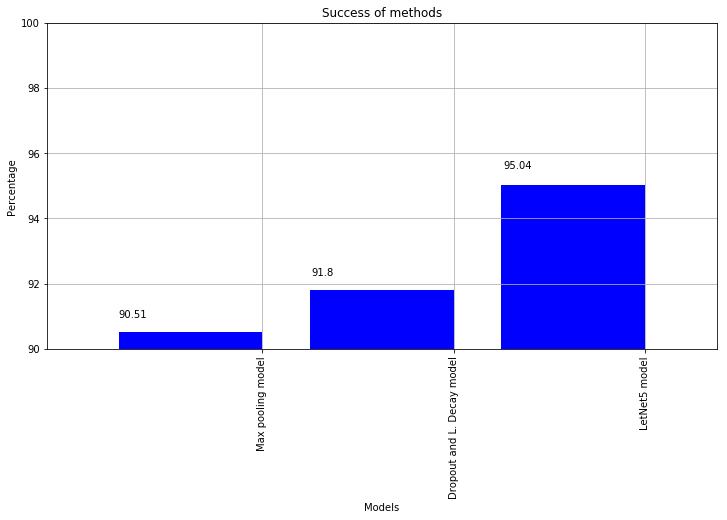

In [17]:
import pandas as pd
from collections import OrderedDict
def plotSuccess():
    s = pd.Series(methodDict)
    s.sort()
    
    # Colors
    ax = s.plot(kind='bar', figsize=(12, 6))

    
    for p in ax.patches:
        ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.ylim([90.0, 100.0])
    plt.xlim([-0.5, 3])
    plt.xlabel('Models')
    plt.ylabel('Percentage')
    plt.title('Success of methods')
     
    plt.show()
plotSuccess()    

### Conclusion

We've got the best score with LetNet5 aplying Dropout and Learning Rate Decay. So we've haven't gotten 97%. Maybe changing some parameters it will perform better.